# Computer Vision 2022 Assignment 2: Image matching and retrieval

In this assignment, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the assignment:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

This assignment will have a minimum hurdle of 40%. You will fail if you can not reach the minimum hurdle.

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'
    # Or
    jupyter nbconvert Assignment2.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

**Please do try this ccommond early before the last day! As the commend may be a little bit difference depending on your computer and the environment.**

This will also remove the preamble text from each question. We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

This being the second assignment, we have provided less strict direction this time and you have more flexibility to choose how you answer each question. However you still need to ensure the outputs and report are clear and easy to read. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. Within each category, there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [61]:
# Numpy is the main package for scientific computing with Python. 
import numpy as np
import cv2

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def draw_outline(ref, query, model):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)
    

    return dst
    
    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)
    # print(img.shape)

    plt.axis('off')
    plt.title('draw outline')
    plt.imshow(img, 'gray')
    plt.show()  
    

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)
    
    return img3


# Matching an object in a pair of images (45%)

### draw key points and macthes by using orb method

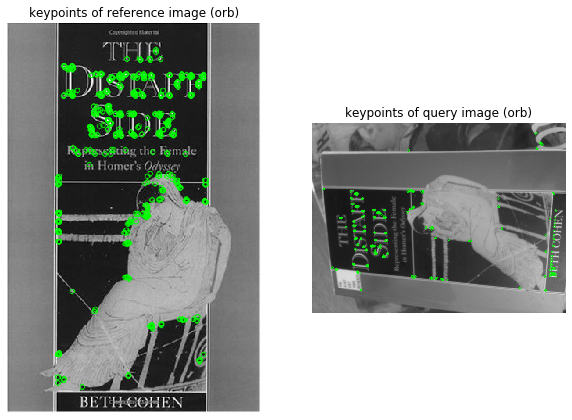

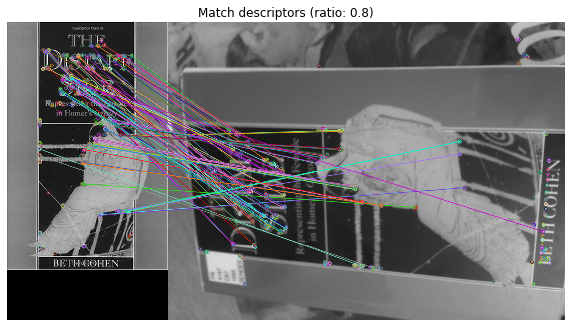

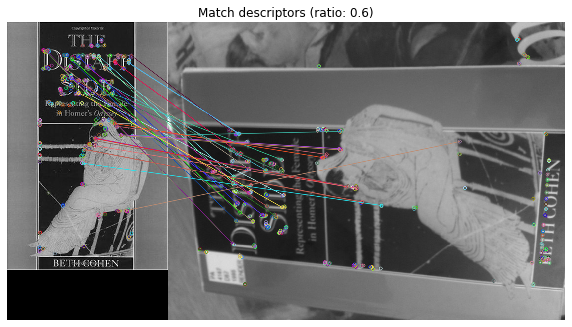

In [63]:
# Your code for descriptor matching tests here

# load image at gray scale
img1 = cv2.imread('A2_smvs/book_covers/Reference/001.jpg', 0)
img2 = cv2.imread('A2_smvs/book_covers/Query/001.jpg', 0)
color_query = cv2.imread('A2_smvs/book_covers/Query/001.jpg')

# compute detector and descriptor
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# draw keypoints
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

reference_image = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)

ax1.imshow(reference_image)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')

plt.show()

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors.
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
good_without_list = []
for m,n in matches:
    if m.distance < 0.8 * n.distance:
        good.append([m])  
        good_without_list.append(m)

# draw matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None)

plt.title('Match descriptors (ratio: 0.8)')
plt.axis('off')
plt.imshow(img3)
plt.show()

# Apply ratio test
good1 = []
good1_without_list = []
for m,n in matches:
    if m.distance < 0.6 * n.distance:
        good1.append([m])  
        good1_without_list.append(m)

img4 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good1, None)
    

plt.title('Match descriptors (ratio: 0.6)')
plt.axis('off')
plt.imshow(img4)
plt.show()


**Change the ratio**

By compare the ration 0.6 and the rtatio  0.8, we can get:

- when the ratio become small, the keypoints and match numbers become less.
- when the ratio become large, the keypoints and match numbers become more.


***

### draw outline and inliers by using regular method

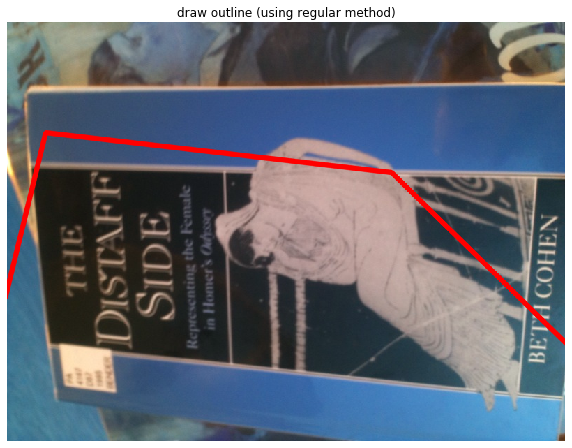

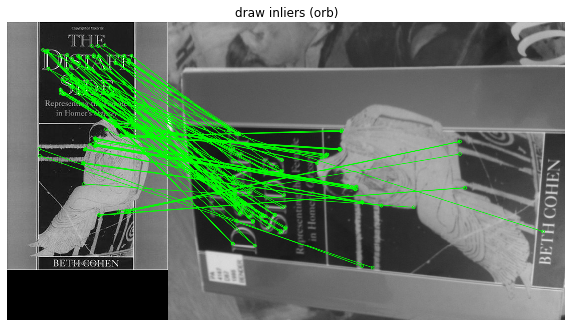

number of detected inliers:  131
number of detected outliers:  0.0


In [64]:
# Your code to display book location here

# using  (orb ( asdasdasdasdasd(cv2.findHomography)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

plt.axis('off')
plt.title('draw outline (using regular method)')
plt.imshow(outline_sift, 'gray')
plt.show()  


# draw inliers
inliers_sift = draw_inliers(img1, img2, kp1, kp2, good_without_list, matchesMask)

plt.axis('off')
plt.title('draw inliers (orb)')
plt.imshow(inliers_sift, 'gray')
plt.show()

inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)

***Summary***

When I try to use regular method, I notice draw oulines does not work correctly. 

***

### Draw outline and inliers by using RANSAC

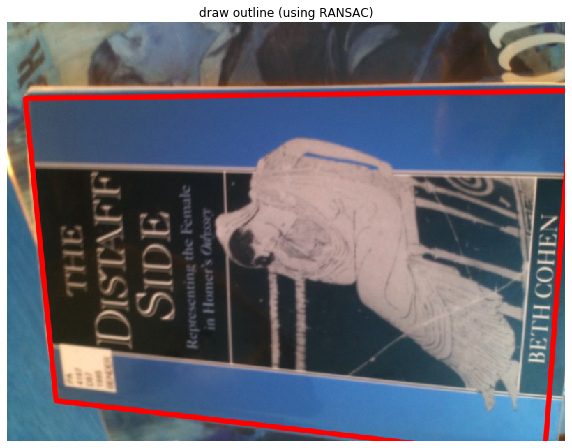

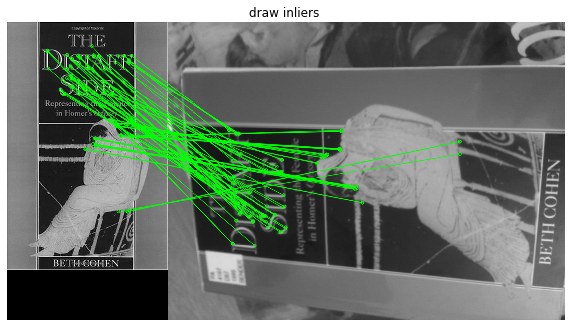

number of detected inliers:  100
number of detected outliers:  31.0


In [65]:
# Your code to display book location after RANSAC here
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

plt.axis('off')
plt.title('draw outline (using RANSAC)')
plt.imshow(outline_sift, 'gray')
plt.show()  


# draw inliers
inliers_sift = draw_inliers(img1, img2, kp1, kp2, good_without_list, matchesMask)

plt.axis('off')
plt.title('draw inliers ')
plt.imshow(inliers_sift, 'gray')
plt.show()


inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)

***Summary***

Compare to the RANSAC and the regular method, I notice the number of dectected inliers is different. The ***total number of detected points are 131***, and when I use ***RANSAC*** method, the number of detected inliers are ***only 100***, however, when I use ***regular method***, the number of detected inliers are ***131***. There is ***a difference of 31 points***. However, it may influence when draw outlines because these 31 points should not be caculated in the inliers.

***

In [66]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

## Book cover (example book_cover_025)

### draw keypoints of reference image and query image (using orb, brisk and sift)

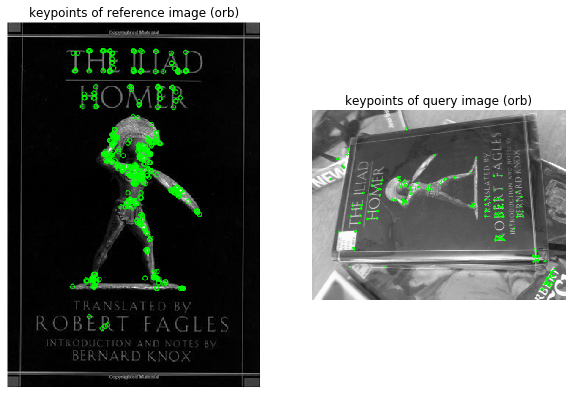

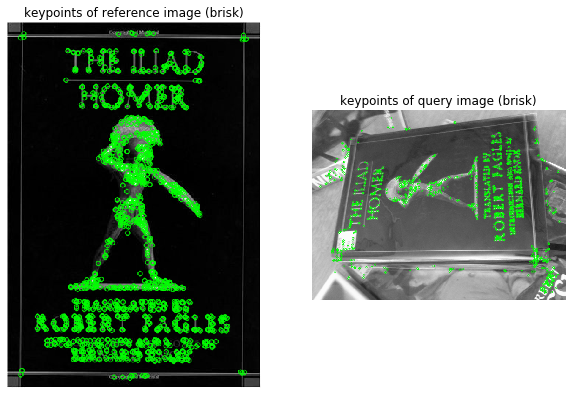

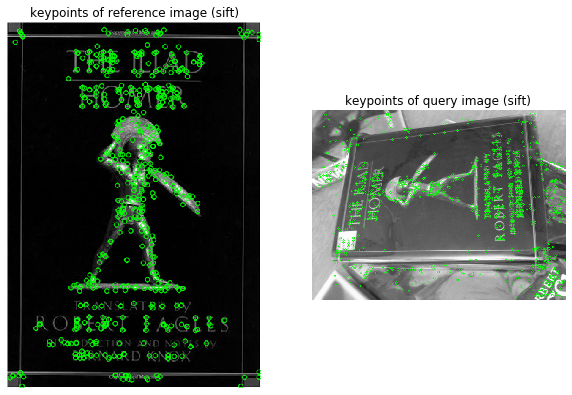

In [67]:
# load image at gray scale
img1 = cv2.imread('A2_smvs/book_covers/Reference/025.jpg', 0)
img2 = cv2.imread('A2_smvs/book_covers/Query/025.jpg', 0)
color_query = cv2.imread('A2_smvs/book_covers/Query/025.jpg')


# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')


# use brisk
kp5, des5 = detectAndDescribe(img1, 'brisk')
kp6, des6 = detectAndDescribe(img2, 'brisk')

reference_image_brisk = cv2.drawKeypoints(img1, kp5, des5, color=(0,255,0), flags=0)
query_image_brisk = cv2.drawKeypoints(img2, kp6, des6, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_brisk)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (brisk)')

ax2.imshow(query_image_brisk)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (brisk)')


# use sift
kp3, des3 = detectAndDescribe(img1, 'sift')
kp4, des4 = detectAndDescribe(img2, 'sift')

reference_image_sift = cv2.drawKeypoints(img1, kp3, des3, color=(0,255,0), flags=0)
query_image_sift = cv2.drawKeypoints(img2, kp4, des4, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_sift)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (sift)')

ax2.imshow(query_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')


plt.show()

### summary of finding key ponits part

In ***getting keypoints***, the shift works better than orb and the brisk, it returns more key points in the query image and the reference image.

In [68]:
def createMatcher(method):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    return bf

***

### Draw match part (using orb and sift)

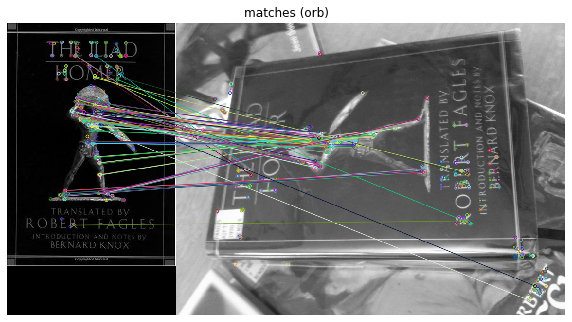

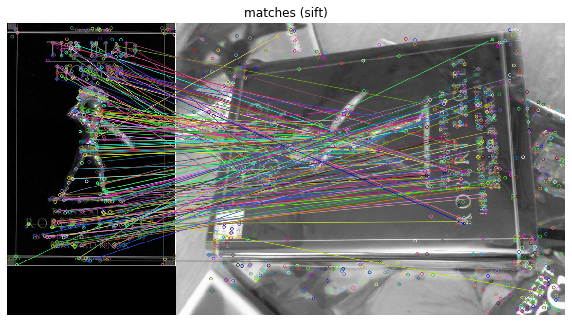

In [69]:
bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)

# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

# draw matches
matches_orb = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_orb, None)
matches_sift = cv2.drawMatchesKnn(img1, kp3, img2, kp4, good_sift, None)

plt.title('matches (orb)')
plt.axis('off')
plt.imshow(matches_orb)
plt.show()

plt.title('matches (sift)')
plt.axis('off')
plt.imshow(matches_sift)
plt.show()


### Summary of drawing match part

In this part, I notice some macthes in ***orb method*** matches the keypoints ***outside the reference book***, which are ***wrong matches***. (shown in the picture: wrong matches)

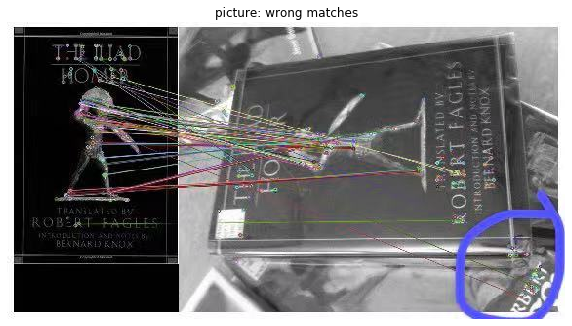

In [70]:
img = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/WechatIMG54.jpeg')

plt.axis('off')
plt.title('picture: wrong matches')
plt.imshow(img)
plt.show()

***

### Draw outlines and inliers (using orb)

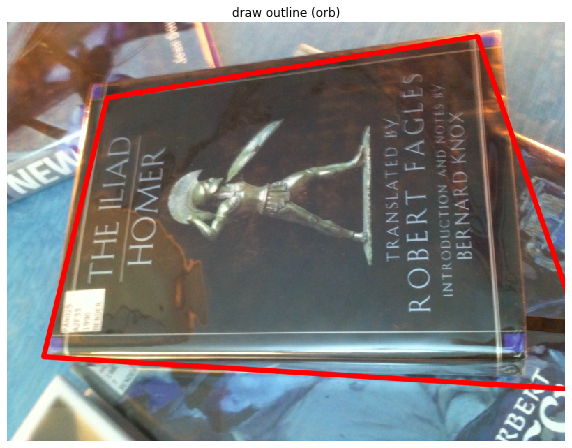

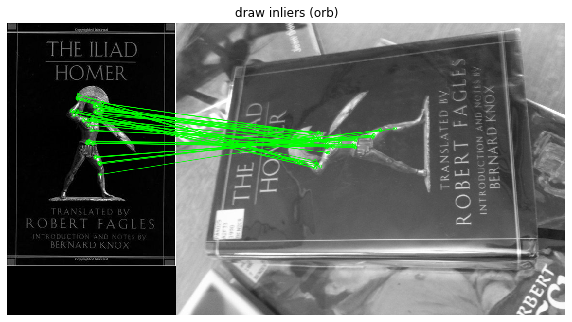

number of detected inliers:  57
number of detected outliers:  36.0
Ratio:  0.6129032258064516


In [71]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_orb = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

plt.axis('off')
plt.title('draw outline (orb)')
plt.imshow(outline_orb, 'gray')
plt.show()  


# draw inliers
inliers_orb = draw_inliers(img1, img2, kp1, kp2, good_orb_without_list, matchesMask)

plt.axis('off')
plt.title('draw inliers (orb)')
plt.imshow(inliers_orb, 'gray')
plt.show()

inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Draw outlines and inliers (using sift)

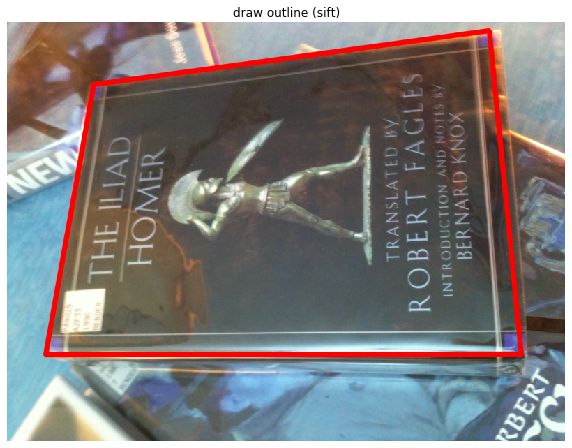

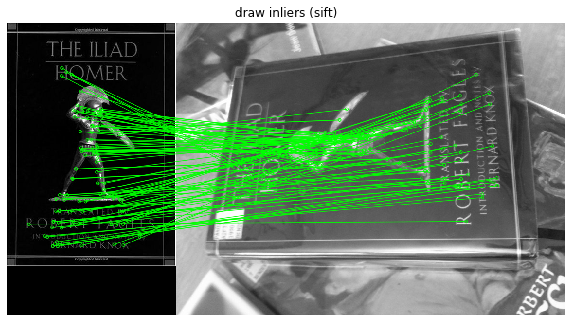

number of detected inliers:  106
number of detected outliers:  70.0
Ratio:  0.6022727272727273


In [72]:
src_pts = np.float32([kp3[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp4[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

plt.axis('off')
plt.title('draw outline (sift)')
plt.imshow(outline_sift, 'gray')
plt.show()  


# draw inliers
inliers_sift = draw_inliers(img1, img2, kp3, kp4, good_sift_without_list, matchesMask)

plt.axis('off')
plt.title('draw inliers (sift)')
plt.imshow(inliers_sift, 'gray')
plt.show()

inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Summary

In image 25 from book_covers. we can see when we use orb method to get the outline, it is not very precise, however, sift method works good.


***Reason (why orb method will fail)***: 
when I use orb method, the keypoints of query image do not detect many keypoints in this area (draw in the picture_01), the key points which are detected are focus on the person (middle in the book cover). So when do matches, some keyponits will match the keypoints which detect ouside the book cover, this is why we can not get the correct area when we draw outlines.


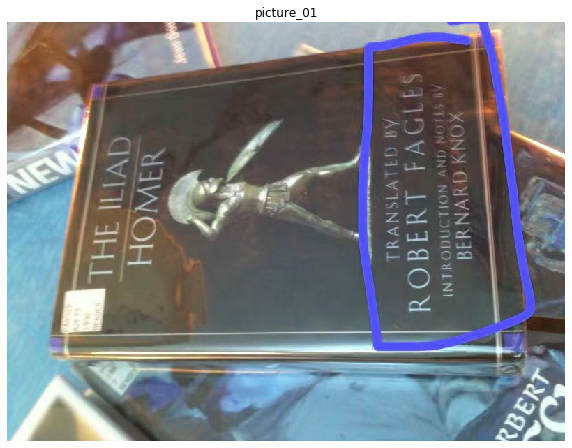

In [73]:
img = cv2.imread('book_cover025.jpeg')

plt.axis('off')
plt.title('picture_01')
plt.imshow(img)
plt.show()

***

## museum paintings (example museum_paintings_064)

### draw keypoints of reference image and query image (using orb, brisk and sift)

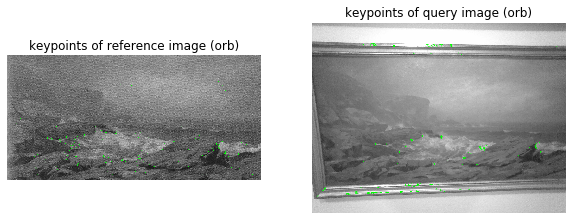

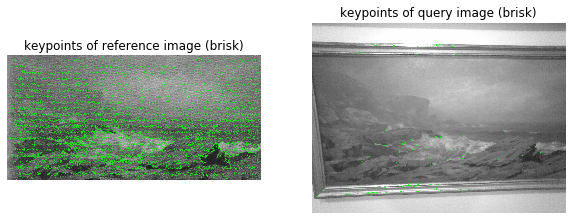

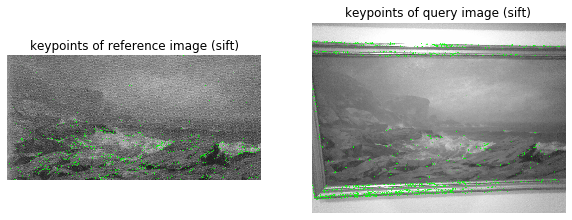

In [74]:
# load image at gray scale
img1 = cv2.imread('A2_smvs/museum_paintings/Reference/064.jpg', 0)
img2 = cv2.imread('A2_smvs/museum_paintings/Query/064.jpg', 0)
color_query = cv2.imread('A2_smvs/museum_paintings/Query/064.jpg')


# use orb
kp1, des1 = detectAndDescribe(img1, 'orb')
kp2, des2 = detectAndDescribe(img2, 'orb')

reference_image_orb = cv2.drawKeypoints(img1, kp1, des1, color=(0,255,0), flags=0)
query_image_orb = cv2.drawKeypoints(img2, kp2, des2, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_orb)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (orb)')

ax2.imshow(query_image_orb)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (orb)')


# use brisk
kp5, des5 = detectAndDescribe(img1, 'brisk')
kp6, des6 = detectAndDescribe(img2, 'brisk')

reference_image_brisk = cv2.drawKeypoints(img1, kp5, des5, color=(0,255,0), flags=0)
query_image_brisk = cv2.drawKeypoints(img2, kp6, des6, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_brisk)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (brisk)')

ax2.imshow(query_image_brisk)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (brisk)')


# use sift
kp3, des3 = detectAndDescribe(img1, 'sift')
kp4, des4 = detectAndDescribe(img2, 'sift')

reference_image_sift = cv2.drawKeypoints(img1, kp3, des3, color=(0,255,0), flags=0)
query_image_sift = cv2.drawKeypoints(img2, kp4, des4, color=(0,255,0), flags=0)


fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(reference_image_sift)
ax1.set_axis_off()
ax1.set_title('keypoints of reference image (sift)')

ax2.imshow(query_image_sift)
ax2.set_axis_off()
ax2.set_title('keypoints of query image (sift)')


plt.show()

### summary of finding key ponits part

In getting keypoints, the shift works better than orb and the brisk, it returns more key points in the query image and the reference image.

***

### Draw match part (using orb and sift)

In [75]:
def createMatcher(method):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    return bf

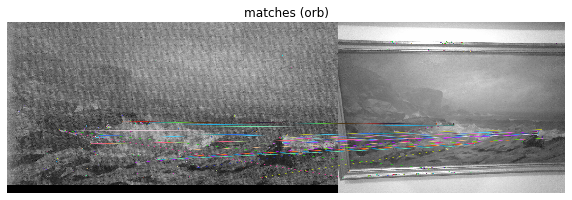

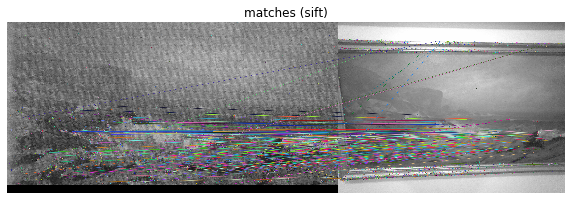

In [76]:
bf_orb = createMatcher('orb')
bf_sift = createMatcher('sift')

matches_orb = bf_orb.knnMatch(des1, des2, k=2) 
matches_sift = bf_sift.knnMatch(des3, des4, k=2) 

# Apply ratio test (orb)
good_orb = []
good_orb_without_list = []
for m,n in matches_orb:
    if m.distance < 0.8 * n.distance:
        good_orb.append([m])
        good_orb_without_list.append(m)

# Apply ratio test (sift)
good_sift = []
good_sift_without_list = []
for m,n in matches_sift:
    if m.distance < 0.8 * n.distance:
        good_sift.append([m])
        good_sift_without_list.append(m)

# draw matches
matches_orb = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_orb, None)
matches_sift = cv2.drawMatchesKnn(img1, kp3, img2, kp4, good_sift, None)

plt.title('matches (orb)')
plt.axis('off')
plt.imshow(matches_orb)
plt.show()

plt.title('matches (sift)')
plt.axis('off')
plt.imshow(matches_sift)
plt.show()


### Summary of drawing match part

In this part, two pictures are draw all mactches correctly.

---

### Draw outlines and inliers (using orb)

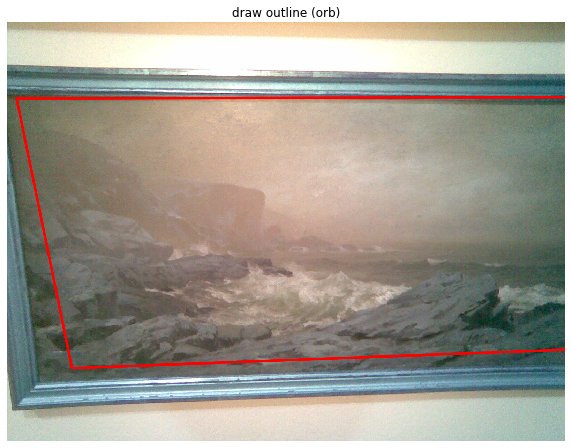

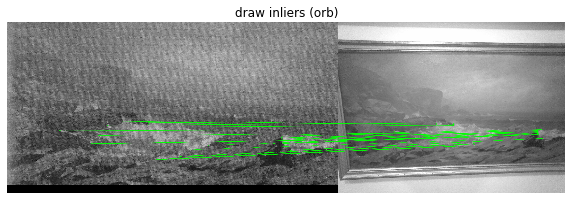

number of detected inliers:  52
number of detected outliers:  9.0
Ratio:  0.8524590163934426


In [77]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_orb_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_orb = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

plt.axis('off')
plt.title('draw outline (orb)')
plt.imshow(outline_orb, 'gray')
plt.show()  


# draw inliers
inliers_orb = draw_inliers(img1, img2, kp1, kp2, good_orb_without_list, matchesMask)

plt.axis('off')
plt.title('draw inliers (orb)')
plt.imshow(inliers_orb, 'gray')
plt.show()


inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Draw outlines and inliers (using sift)

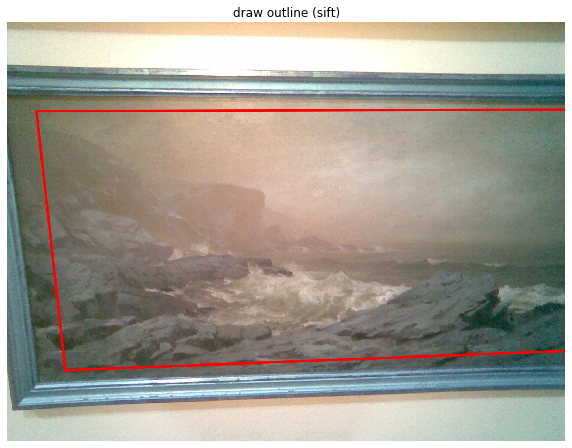

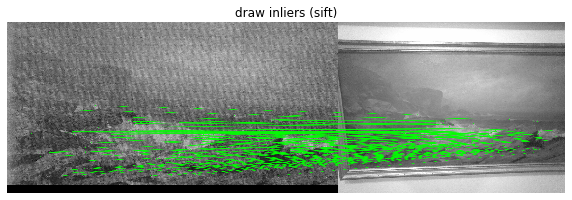

number of detected inliers:  142
number of detected outliers:  48.0
Ratio:  0.7473684210526316


In [78]:
src_pts = np.float32([kp3[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
dst_pts = np.float32([kp4[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# draw outline
dst = draw_outline(img1, color_query, model) 

img = color_query.copy()
outline_sift = cv2.polylines(img,[np.int32(dst)],True,255,5,cv2.LINE_AA)

plt.axis('off')
plt.title('draw outline (sift)')
plt.imshow(outline_sift, 'gray')
plt.show()  


# draw inliers
inliers_sift = draw_inliers(img1, img2, kp3, kp4, good_sift_without_list, matchesMask)

plt.axis('off')
plt.title('draw inliers (sift)')
plt.imshow(inliers_sift, 'gray')
plt.show()


inliers_number = np.sum(matchesMask)
outline_number = len(matchesMask) - np.sum(matchesMask)
ratio = float(np.sum(matchesMask)) / float(len(matchesMask))

print("number of detected inliers: ", inliers_number)
print("number of detected outliers: ", outline_number)
print("Ratio: ", ratio)

### Summary

**Ratio = number of inlier/number of matches**

I compare the ratio of two method (orb and sift), when the ratio become smaller (should bigger than 0), the ouline will become more acurrate. By compare ***picture draw outline (orb)*** and ***picture draw outline (sift)***, we can see the **picture draw outline (sift)** works better. By the way, the ratio is 0.747 (sift method) which is smaller than 0.852 (orb method).

***

# What am I looking at? (40%)

### At first, I try use orb method to get matches

***this case is one of a suucessful cases (book_covers 12) :***

In [79]:
# load files in the folder
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 0)
        if img is not None:
            images.append(img)
    return images

In [94]:
# Your code to iddntify query objects and measure search accuracy for data set here 

book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/012.jpg', 0)
test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)

max_value = max(list)
index = list.index(max_value)

print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

We get the number 18 image is the best, it has best score : 56 (points matches).


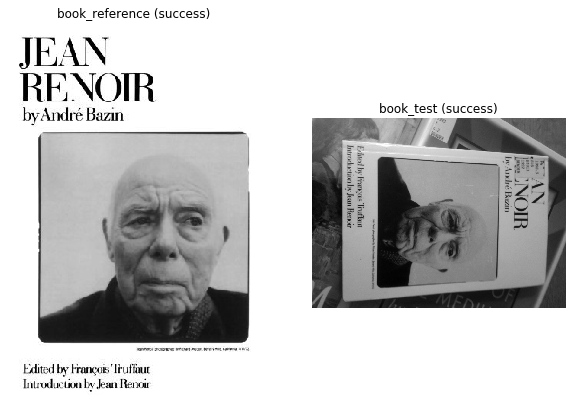

In [95]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (success)')

ax2.imshow(book_test)
ax2.set_axis_off()
ax2.set_title('book_test (success)')

plt.show()

***this case is one of a failed cases (book_covers 23) :***

In [90]:
# Your code to iddntify query objects and measure search accuracy for data set here 

book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/081.jpg', 0)
test_kp, test_des = detectAndDescribe(book_test, 'orb')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'orb')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('orb')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)

max_value = max(list)
index = list.index(max_value)

print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

We get the number 47 image is the best, it has best score : 23 (points matches).


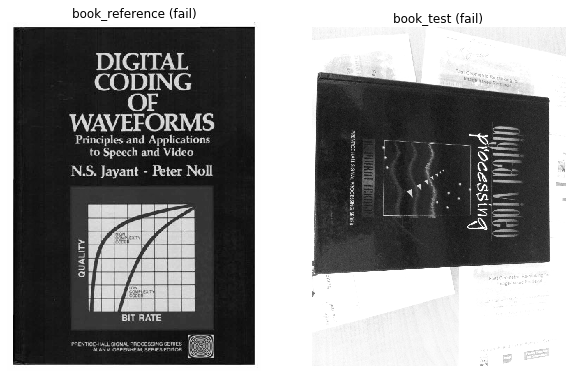

In [91]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (fail)')

ax2.imshow(book_test)
ax2.set_axis_off()
ax2.set_title('book_test (fail)')

plt.show()

In [1]:
from ipysheet import sheet, cell, row, column, cell_range

ModuleNotFoundError: No module named 'ipysheet'

#### Result (use orb)

test case: 10, 12, 13, 67, 56, 89, 46, 23, 59, 81

successful case: 12(56), 13(54)                     

failed case:    
image 10 
image 23
image 59
image 67
image 56
image 89
image 46
image 81(23)

accuracy: **20%**

#### The reason (why will fail):

- The main reason I think when we use orb method, it can not detect many keypoints of each images, so it is hard to get correct macthes.

***

**I find the accuracy is pretty low, so I try to change the method of detecting keypoints.**

### Using sift method to get matches

***this case is one of a sucessful cases (book_covers 81)***

In [88]:
# Your code to iddntify query objects and measure search accuracy for data set here 

book_ref = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Reference')
book_Q = load_images_from_folder('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query')

# randomly choose a query picture
book_test = cv2.imread('/Users/malujie/Computer-vision/assignment 2/clean/A2_smvs/book_covers/Query/081.jpg', 0)
test_kp, test_des = detectAndDescribe(book_test, 'sift')
book_test_key = cv2.drawKeypoints(book_test, test_kp, test_des, color=(0,255,0), flags=0)

list = []
for x in range(0, 100):
    kp, des = detectAndDescribe(book_ref[x], 'sift')

    reference_image_sift = cv2.drawKeypoints(book_ref[x], kp, des, color=(0,255,0), flags=0)

    bf_sift = createMatcher('sift')
    matches_sift = bf_sift.knnMatch(des, test_des, k=2) 

    # Apply ratio test (sift)
    good_sift = []
    good_sift_without_list = []
    for m,n in matches_sift:
        if m.distance < 0.8 * n.distance:
            good_sift.append([m])
            good_sift_without_list.append(m)

    # draw matches
    # matches_sift = cv2.drawMatchesKnn(book_ref[x], kp, book_test, test_kp, good_sift, None)
    
    
    if len(good_sift_without_list) > 4:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)
        dst_pts = np.float32([test_kp[m.trainIdx].pt for m in good_sift_without_list]).reshape(-1,1,2)

        model, matchesMask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
        inliers_number = np.sum(matchesMask)
        list.append(inliers_number)

max_value = max(list)
index = list.index(max_value)

print("We get the number", index, "image is the best, it has best score :", max_value, "(points matches).")

We get the number 62 image is the best, it has best score : 155 (points matches).


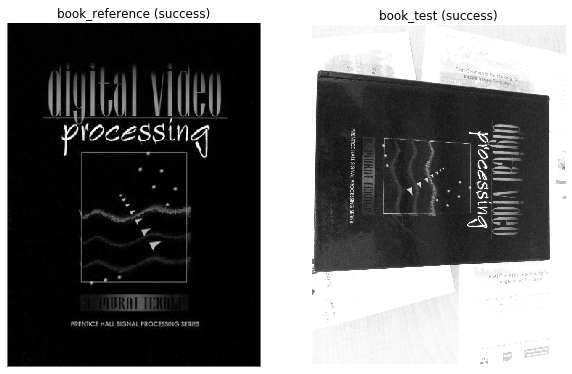

In [85]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(book_ref[index])
ax1.set_axis_off()
ax1.set_title('book_reference (success)')

ax2.imshow(book_test)
ax2.set_axis_off()
ax2.set_title('book_test (success)')

plt.show()

#### Result (use sift)

test case: 10, 12, 13, 67, 56, 89, 46, 23, 59, 81

successful case: 10, 12, 13, 67, 56, 89, 46, 81

failed case: 23, 59

accuracy: **80%**

### Summary

I change the moethod of detecting keypoints, from orb method to sift method. It works good and the accuracy increase **60%** (from 20% to 80%).

I also notice when I do pairs, some piuctures do not have more than 4 points pairs, so the code will report error (in cv2.findHomography step). I add a condition **[if len(good_without_list) > 4]** to avoid this situation. However, this is not perfect, becasue when images do not have four points' pairs, it will skip these images, so the index will be confusion. This is the main reason will cause case failed.


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [86]:
# Your code to search images and display results here

***Your description of what you have done, and explanation of results, here***

# Question 3 (10%)

In Question 1, We hope that `ratio_test` can provide reasonable results for RANSAC. However, if it fails, the RANSAC may not get good results. In this case, we would like to try an improved matching method to replace the `ratio_test`. Here, the `gms_matcher` is recommened. You need to implement it and save results of 3 image pairs (you can select any image pairs from the dataset),
where you new method is better than 'ratio_test'.


1. Hint 1: `cv2.xfeatures2d.matchGMS()` can be used, but you need to install the opencv-contrib by `pip install opencv-contrib-python`
2. Hint 2: You do not need use KNN matching, because GMS does not require second nearest neighbor.
3. Hint 3: You need to change the parameters in `cv2.ORB_create()` for best results. See the setting in Github.
4. Hint 4: If your are interested in more details. Read the paper "GMS: Grid-based Motion Statistics for Fast, Ultra-robust Feature Correspondence", and the Github "https://github.com/JiawangBian/GMS-Feature-Matcher".

***Your results here***

# Question 4: Reflection Questions (5%)

1. Describe the hardest situation you faced during the first two assignments. And how you overcome it? (3%)


2. How do you plan to finish the assignment to meet tight deadline? (2%)